In [1]:
import numpy as np
import tensorflow as tf
import h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
import skimage
from PIL import Image
from skimage.measure import compare_ssim,compare_psnr
np.random.seed(73)

In [2]:
def residual_block(input_tense):
    tmp1 = tf.nn.relu(tf.layers.batch_normalization(
        tf.layers.conv2d(input_tense,64,[3,3],[1,1], padding='SAME')))
    tmp2 = tf.nn.relu(tf.layers.batch_normalization(
        tf.layers.conv2d(tmp1,16,[2,2],[1,1], padding='SAME')))
    tmp3 = tf.layers.batch_normalization(
        tf.layers.conv2d(tmp2,1,[1,1],[1,1], padding='SAME'))
    tmp4 = tmp3 + input_tense
    return tmp4

In [3]:
from xy_inception_tf_model import inception_module,inception_model

def recon_NN(comp_in, NC, block_size, stride_size, reuse=False):
    with tf.variable_scope('Decomp_NN_884_fix_code_RB_SF', reuse=reuse):
    
        with tf.name_scope('Pre_dcomp'):
            pdcomp = residual_block(comp_in)
            print(pdcomp)

        with tf.name_scope('Dcompress_Conv'):
            dcomp = tf.layers.conv2d_transpose(pdcomp,NC,[block_size,block_size],[stride_size,stride_size], padding='VALID')
            print(dcomp)


        with tf.name_scope('inception_model'):
            outputs=inception_model(dcomp,8)
        
        return outputs

In [4]:
block_size = 8
stride_size = 8

nx=128
ny=240
ncomp=4

NC = 1

#These two numbers are used to scale compressed data for decompression
sc_int=23.
Q_scale=1.

In [5]:
with tf.name_scope('Compress_Conv_f32'):
    compf32 = tf.placeholder(tf.float32,shape=[None,nx,ny,ncomp])
print(compf32)

Tensor("Compress_Conv_f32/Placeholder:0", shape=(?, 128, 240, 4), dtype=float32)


In [6]:
recon=recon_NN(compf32, NC, block_size, stride_size)
print("\nrecon: " + str(recon))

Tensor("Decomp_NN_884_fix_code_RB_SF/Pre_dcomp/add:0", shape=(?, 128, 240, 4), dtype=float32)
Tensor("Decomp_NN_884_fix_code_RB_SF/Dcompress_Conv/conv2d_transpose/BiasAdd:0", shape=(?, 1024, 1920, 1), dtype=float32)
Tensor("Decomp_NN_884_fix_code_RB_SF/inception_model/conv2d/BiasAdd:0", shape=(?, 1024, 1920, 64), dtype=float32)
Tensor("Decomp_NN_884_fix_code_RB_SF/inception_model/batch_normalization/FusedBatchNorm:0", shape=(?, 1024, 1920, 64), dtype=float32)
Tensor("Decomp_NN_884_fix_code_RB_SF/inception_model/conv2d_1/BiasAdd:0", shape=(?, 1024, 1920, 32), dtype=float32)
Tensor("Decomp_NN_884_fix_code_RB_SF/inception_model/batch_normalization_1/FusedBatchNorm:0", shape=(?, 1024, 1920, 32), dtype=float32)
Tensor("Decomp_NN_884_fix_code_RB_SF/inception_model/LeakyRelu/Maximum:0", shape=(?, 1024, 1920, 96), dtype=float32)
Tensor("Decomp_NN_884_fix_code_RB_SF/inception_model/inception_modules_0/conv2d/BiasAdd:0", shape=(?, 1024, 1920, 64), dtype=float32)
Tensor("Decomp_NN_884_fix_code_RB

In [7]:
trained_model='./model_884_4bit_fix_code_RB_mix_9/model_200000.ckpt-200001'
saver = tf.train.Saver()

In [8]:
def run_recon(data_in):
    with tf.Session() as sess:
        saver.restore(sess,trained_model)
        dip=sess.run(recon,feed_dict={compf32:data_in})
            
    return dip

In [9]:
def read_COMPINT_PNG(f_pt, f_pn):
    o4=np.zeros([1, int(nx*2), int(ny*2), ncomp])
    for j in range(ncomp):
        inname = f_pt + f_pn + "_" + str(j) + ".png"
        print("  Input: " + inname)
        tim=Image.open(inname)
        tima=np.array(tim)
        o4[0,:,:,j] = tima[:,:]
        
    return o4

In [10]:
F_pt = './PNG_out/'
F_pn = 'F1'

C_data = read_COMPINT_PNG(F_pt, F_pn)

print("C_data shape= " + str(C_data.shape) + " , type= " + str(C_data.dtype) + " , max= " + str(np.max(C_data)) 
      + " , min= " + str(np.min(C_data)) + " , mean= " + str(np.mean(C_data)))

  Input: ./PNG_out/F1_0.png
  Input: ./PNG_out/F1_1.png
  Input: ./PNG_out/F1_2.png
  Input: ./PNG_out/F1_3.png
C_data shape= (1, 256, 480, 4) , type= float64 , max= 209.0 , min= 80.0 , mean= 138.04151611328126


In [11]:
C_data = (C_data-128.)/(sc_int*Q_scale) #Subtract the 128 value and scalue
C_data = C_data.astype(np.float32)

print("C_data shape= " + str(C_data.shape) + " , type= " + str(C_data.dtype) + " , max= " + str(np.max(C_data)) 
      + " , min= " + str(np.min(C_data)) + " , mean= " + str(np.mean(C_data)))

C_data shape= (1, 256, 480, 4) , type= float32 , max= 3.5217392 , min= -2.0869565 , mean= 0.43658763


In [12]:
#Because of GPU memory limiation, we are doing decompression in 4 quarters. Note: this is even better than crops with same model
cxs_s={}; cys_s={};

cxs_s[0]=0; cys_s[0]=0
cxs_s[1]=nx; cys_s[1]=0
cxs_s[2]=0; cys_s[2]=ny
cxs_s[3]=nx; cys_s[3]=ny

for i in range(4):
    print(str(i) + " cxs= " + str(cxs_s[i]) + " , cys= " + str(cys_s[i]))

0 cxs= 0 , cys= 0
1 cxs= 128 , cys= 0
2 cxs= 0 , cys= 240
3 cxs= 128 , cys= 240


In [13]:
Dips={}
for i in range(4):
    cxs=cxs_s[i]; cxe=cxs+nx
    cys=cys_s[i]; cye=cys+ny
    c_f=np.zeros([1,nx,ny,ncomp])
    c_f[0,:,:,:]=C_data[0,cxs:cxe,cys:cye,:]
    print(str(i) + " | c_f shape= " + str(c_f.shape) + " , max= " + str(np.max(c_f)) 
      + " , min= " + str(np.min(c_f)) + " , mean= " + str(np.mean(c_f)))
    Dips[i]=run_recon(c_f)
    print("  shape: " + str(Dips[i].shape))

0 | c_f shape= (1, 128, 240, 4) , max= 2.08695650100708 , min= -1.2173912525177002 , mean= 0.19345066161689223
INFO:tensorflow:Restoring parameters from ./model_884_4bit_fix_code_RB_mix_9/model_200000.ckpt-200001
  shape: (1, 1024, 1920, 1)
1 | c_f shape= (1, 128, 240, 4) , max= 3.2608695030212402 , min= -1.7826087474822998 , mean= 0.2758548440792159
INFO:tensorflow:Restoring parameters from ./model_884_4bit_fix_code_RB_mix_9/model_200000.ckpt-200001
  shape: (1, 1024, 1920, 1)
2 | c_f shape= (1, 128, 240, 4) , max= 2.4347825050354004 , min= -1.39130437374115 , mean= 0.4195464642146968
INFO:tensorflow:Restoring parameters from ./model_884_4bit_fix_code_RB_mix_9/model_200000.ckpt-200001
  shape: (1, 1024, 1920, 1)
3 | c_f shape= (1, 128, 240, 4) , max= 3.5217392444610596 , min= -2.08695650100708 , mean= 0.8574986458411634
INFO:tensorflow:Restoring parameters from ./model_884_4bit_fix_code_RB_mix_9/model_200000.ckpt-200001
  shape: (1, 1024, 1920, 1)


In [14]:
xs_s={}; ys_s={};
Nx=1024; Ny=1920

xs_s[0]=0; ys_s[0]=0
xs_s[1]=Nx; ys_s[1]=0
xs_s[2]=0; ys_s[2]=Ny
xs_s[3]=Nx; ys_s[3]=Ny

for i in range(4):
    print(str(i) + " xs= " + str(xs_s[i]) + " , ys= " + str(ys_s[i]))

0 xs= 0 , ys= 0
1 xs= 1024 , ys= 0
2 xs= 0 , ys= 1920
3 xs= 1024 , ys= 1920


In [15]:
shape_o=[1,int(Nx*2),int(Ny*2),1]
Dip=np.zeros(shape_o)
for i in range(4):
    xs=xs_s[i]; xe=xs+Nx
    ys=ys_s[i]; ye=ys+Ny
    Dip[0,xs:xe,ys:ye,0]=Dips[i][0,:,:,0]

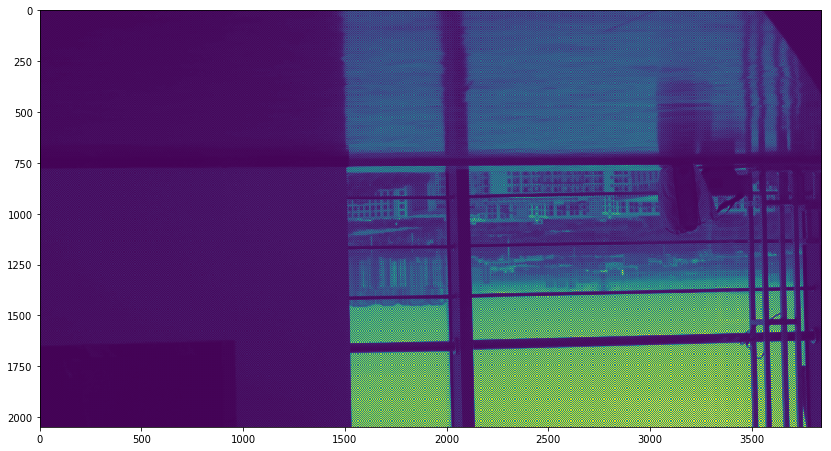

In [16]:
plt.figure(figsize=(14, 18))
plt.imshow(Dip[0,:,:,0])

In [17]:
def write_hdf5(x,filename):
    with h5py.File(filename, 'w') as h:
        h.create_dataset('data', data=x, shape=x.shape)

In [18]:
write_hdf5(Dip,'image_884_rec_CI.h5')